In [ ]:
#Improrting libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Load the dataset
df = pd.read_csv('books_with_blurbs.csv')

# Display the first few rows and basic information about the dataset
df.head()


,ISBN,Title,Author,Year,Publisher,Blurb
0,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,"Here, for the first time in paperback, is an o..."
1,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,"The fascinating, true story of the world's dea..."
2,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,Winnie and Helen have kept each others worst s...
3,0425176428,What If?: The World's Foremost Military Histor...,Robert Cowley,2000,Berkley Publishing Group,Historians and inquisitive laymen alike love t...
4,1881320189,Goodbye to the Buttermilk Sky,Julia Oliver,1994,River City Pub,This highly praised first novel by fiction wri...


Exploring the data

In [2]:
df.info

<bound method DataFrame.info of              ISBN                                              Title  \
0      0060973129                               Decision in Normandy   
1      0374157065  Flu: The Story of the Great Influenza Pandemic...   
2      0399135782                             The Kitchen God's Wife   
3      0425176428  What If?: The World's Foremost Military Histor...   
4      1881320189                      Goodbye to the Buttermilk Sky   
...           ...                                                ...   
57505  0451458877                                      Tainted Trail   
57506  0399148736                                  Twelve Mile Limit   
57507  0399148841       The Man With the Red Tattoo (James Bond 007)   
57508  0553578979       Iron Fist (Star Wars: X-Wing Series, Book 6)   
57509  0345391101  The Adventures of Lando Calrissian: Lando Calr...   

                  Author  Year                 Publisher  \
0           Carlo D'Este  1991           Ha

In [3]:
df.describe

<bound method NDFrame.describe of              ISBN                                              Title  \
0      0060973129                               Decision in Normandy   
1      0374157065  Flu: The Story of the Great Influenza Pandemic...   
2      0399135782                             The Kitchen God's Wife   
3      0425176428  What If?: The World's Foremost Military Histor...   
4      1881320189                      Goodbye to the Buttermilk Sky   
...           ...                                                ...   
57505  0451458877                                      Tainted Trail   
57506  0399148736                                  Twelve Mile Limit   
57507  0399148841       The Man With the Red Tattoo (James Bond 007)   
57508  0553578979       Iron Fist (Star Wars: X-Wing Series, Book 6)   
57509  0345391101  The Adventures of Lando Calrissian: Lando Calr...   

                  Author  Year                 Publisher  \
0           Carlo D'Este  1991           

In [4]:
df.shape

(57510, 6)

In [5]:
df.isna().sum()

ISBN         0
Title        0
Author       0
Year         0
Publisher    0
Blurb        0
dtype: int64

<b>Data Preprocessing</b>

We’ll clean the blurbs by:
- Lowercasing
- Removing punctuation, digits, special characters
- Tokenizing text (splitting into words)
- Removing stopwords

In [9]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def preprocess_blurb(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)  # remove punctuation and digits
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['cleaned_blurb'] = df['Blurb'].apply(preprocess_blurb)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


<b>Feature Extraction</b>

We convert text into numerical features:
- Using TF-IDF to capture word importance
- Using pre-trained sentiment lexicons (e.g., VADER) to generate labels

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['cleaned_blurb'])


<b>Sentiment Labeling</b> 
- Generating sentiment labels automatically using VADER

In [11]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

def get_sentiment_label(text):
    score = sid.polarity_scores(text)['compound']
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['sentiment'] = df['Blurb'].apply(get_sentiment_label)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...


<b> Model Training and Evaluation</b>

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, df['sentiment'], test_size=0.2, random_state=42)

model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.80      0.59      0.68      3967
     neutral       0.32      0.22      0.26       558
    positive       0.77      0.91      0.83      6977

    accuracy                           0.76     11502
   macro avg       0.63      0.57      0.59     11502
weighted avg       0.76      0.76      0.75     11502



<b> Visualizing Sentiment Distribution</b>

C:\Users\HP\AppData\Local\Temp\ipykernel_37396\3358122449.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=df, palette='coolwarm', order=['positive', 'neutral', 'negative'])


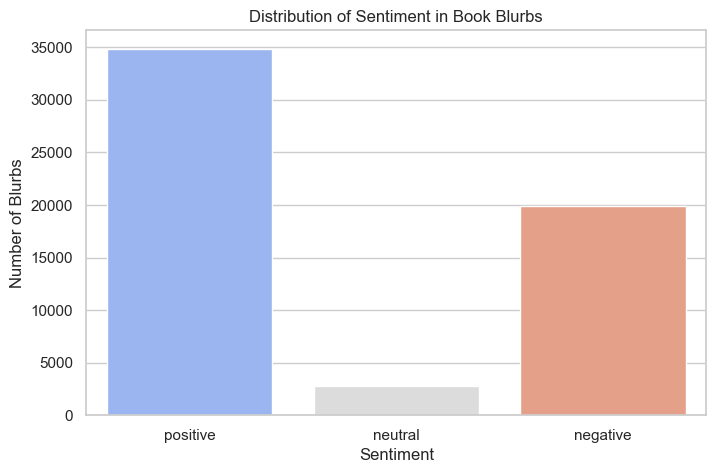

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style='whitegrid')

# Countplot
plt.figure(figsize=(8, 5))
sns.countplot(x='sentiment', data=df, palette='coolwarm', order=['positive', 'neutral', 'negative'])
plt.title('Distribution of Sentiment in Book Blurbs')
plt.xlabel('Sentiment')
plt.ylabel('Number of Blurbs')
plt.show()


In [ ]:
#Checking percentage breakdown of sentiments
sentiment_counts = df['sentiment'].value_counts(normalize=True) * 100
print(sentiment_counts)


sentiment
positive    60.636411
negative    34.562685
neutral      4.800904
Name: proportion, dtype: float64


<b>Fine-Tuning the Classifier</b>

We'll try multiple models and compare them using F1-score:
- Multinomial Naive Bayes (NB)
- Support Vector Machine (SVM)
- Random Forest (RF)
- Logistic Regression (LR)

In [19]:
from sklearn.metrics import f1_score, accuracy_score
import pandas as pd

# Store results for comparison
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    results.append((name, acc, f1))
    print(f"\nModel: {name}")
    print(f"Accuracy: {acc:.3f}, F1-Score: {f1:.3f}")
    print(classification_report(y_test, y_pred, digits=3))

# Convert to DataFrame
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "F1_score"])
best_model_name = results_df.sort_values(by="F1_score", ascending=False).iloc[0]["Model"]
print("\nBest model based on F1-score:")
print(results_df.sort_values(by="F1_score", ascending=False))

# Retrieve best model and make predictions on the full dataset
best_model = models[best_model_name]
df["predicted_sentiment"] = best_model.fit(X_train, y_train).predict(X)

# Save to CSV
output_path = "books_with_predicted_sentiment.csv"
df.to_csv(output_path, index=False)
print(f"\n✅ Predictions saved to: {output_path}")



Model: Naive Bayes
Accuracy: 0.763, F1-Score: 0.752
              precision    recall  f1-score   support

    negative      0.798     0.586     0.675      3967
     neutral      0.317     0.220     0.260       558
    positive      0.772     0.908     0.835      6977

    accuracy                          0.763     11502
   macro avg      0.629     0.571     0.590     11502
weighted avg      0.759     0.763     0.752     11502


Model: Logistic Regression
Accuracy: 0.849, F1-Score: 0.836
              precision    recall  f1-score   support

    negative      0.842     0.803     0.822      3967
     neutral      0.718     0.142     0.237       558
    positive      0.855     0.932     0.892      6977

    accuracy                          0.849     11502
   macro avg      0.805     0.626     0.650     11502
weighted avg      0.844     0.849     0.836     11502


Model: Random Forest
Accuracy: 0.814, F1-Score: 0.804
              precision    recall  f1-score   support

    negative  

<b>Pick the best-performing model (by weighted F1-score)

Save predictions to CSV
</b>


In [20]:
print("\nBest model based on F1-score:")
print(results_df.sort_values(by="F1_score", ascending=False))

# Retrieve best model and make predictions on the full dataset
best_model = models[best_model_name]
df["predicted_sentiment"] = best_model.fit(X_train, y_train).predict(X)


Best model based on F1-score:
                 Model  Accuracy  F1_score
3                  SVM  0.856199  0.848880
1  Logistic Regression  0.849331  0.835999
2        Random Forest  0.813685  0.804411
0          Naive Bayes  0.763346  0.751800


<b>Apply GridSearchCV</b>

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

# Pipeline with vectorizer inside
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('clf', LogisticRegression(max_iter=1000))
])

# Parameter grid
param_grid = {
    'clf__C': [0.1, 1, 10],
    'clf__solver': ['liblinear', 'lbfgs']
}

grid = GridSearchCV(pipeline, param_grid, cv=3, scoring='f1_weighted', verbose=1)
grid.fit(df['cleaned_blurb'], df['sentiment'])

print("\nBest parameters found:")
print(grid.best_params_)
print("Best F1-score: {:.3f}".format(grid.best_score_))


Fitting 3 folds for each of 6 candidates, totalling 18 fits

Best parameters found:
{'clf__C': 10, 'clf__solver': 'liblinear'}
Best F1-score: 0.843


Optionally, focusing on data preprocessing and feature engineering. It generates a simple sentiment score based on blurb length and cleans the text data.

In [6]:
import tensorflow

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re

# Load the dataset
df = pd.read_csv('books_with_blurbs.csv')

# Create a simple sentiment score based on blurb length
df['sentiment_score'] = df['Blurb'].str.len() / df['Blurb'].str.len().max()

# Preprocess the text data
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['processed_blurb'] = df['Blurb'].apply(preprocess_text)

# Display the first few rows of the processed data
df[['Title', 'processed_blurb', 'sentiment_score']].head()



,Title,processed_blurb,sentiment_score
0,Decision in Normandy,here for the first time in paperback is an out...,0.015247
1,Flu: The Story of the Great Influenza Pandemic...,the fascinating true story of the worlds deadl...,0.069219
2,The Kitchen God's Wife,winnie and helen have kept each others worst s...,0.034067
3,What If?: The World's Foremost Military Histor...,historians and inquisitive laymen alike love t...,0.025391
4,Goodbye to the Buttermilk Sky,this highly praised first novel by fiction wri...,0.107241


Building a deep learning model (LSTM) to predict sentiment scores from the processed blurbs. It splits the data, tokenizes the text, pads the sequences, and trains the model.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Load the preprocessed data
df = pd.read_csv('books_with_blurbs.csv')
df['sentiment_score'] = df['Blurb'].str.len() / df['Blurb'].str.len().max()
df['processed_blurb'] = df['Blurb'].apply(lambda x: ' '.join(re.findall(r'\w+', x.lower())))

# Split the data
X_train, X_test, y_train, y_test = train_test_split(df['processed_blurb'], df['sentiment_score'], test_size=0.2, random_state=42)

# Tokenize the text
max_words = 10000
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad the sequences
max_length = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

# Create the model
model = Sequential([
    Embedding(max_words, 16, input_length=max_length),
    LSTM(32),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model
history = model.fit(X_train_pad, y_train, epochs=5, validation_split=0.2, batch_size=32, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test_pad, y_test, verbose=0)
print(f'Test Mean Absolute Error: {mae:.4f}')

# Make predictions on a few samples
sample_texts = X_test[:3]
sample_sequences = tokenizer.texts_to_sequences(sample_texts)
sample_padded = pad_sequences(sample_sequences, maxlen=max_length, padding='post', truncating='post')
predictions = model.predict(sample_padded)

for text, pred in zip(sample_texts, predictions):
    print(f'Text: {text[:50]}...')
    print(f'Predicted sentiment score: {pred[0]:.4f}\
')

print('Model training and evaluation completed.')

C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 89s 67ms/step - loss: 0.0131 - mae: 0.0465 - val_loss: 5.4664e-04 - val_mae: 0.0112
Epoch 2/5
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 43s 38ms/step - loss: 3.8462e-04 - mae: 0.0109 - val_loss: 5.3283e-04 - val_mae: 0.0110
Epoch 3/5
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 83s 72ms/step - loss: 3.6028e-04 - mae: 0.0107 - val_loss: 5.1838e-04 - val_mae: 0.0114
Epoch 4/5
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 65s 56ms/step - loss: 2.9958e-04 - mae: 0.0095 - val_loss: 5.5016e-04 - val_mae: 0.0123
Epoch 5/5
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 63s 39ms/step - loss: 2.4671e-04 - mae: 0.0087 - val_loss: 5.5638e-04 - val_mae: 0.0115
Test Mean Absolute Error: 0.0114
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
Text: a modern knight errant on a quest after evil convi...
Predicted sentiment score: 0.0771
Text: icy sparks an unforgettable heroine in the traditi...
Predicted sentiment score: 0.0970
Text: called elegantly starkly beautiful by the new york...
Predicted sentiment score: 0.0626
Model